# Part 2 - Data Exploration

### First, let's start by importing everything

In [54]:
from proj2.config import PROJ_ROOT, DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGURES_DIR

---

## Load data

In [25]:
from proj2.part2.dataloader import get_data_set_loader

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_data_set_loader()

Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5216
Val   samples: 16
Test  samples: 624


---

# Q1.1 - Exploration of Data

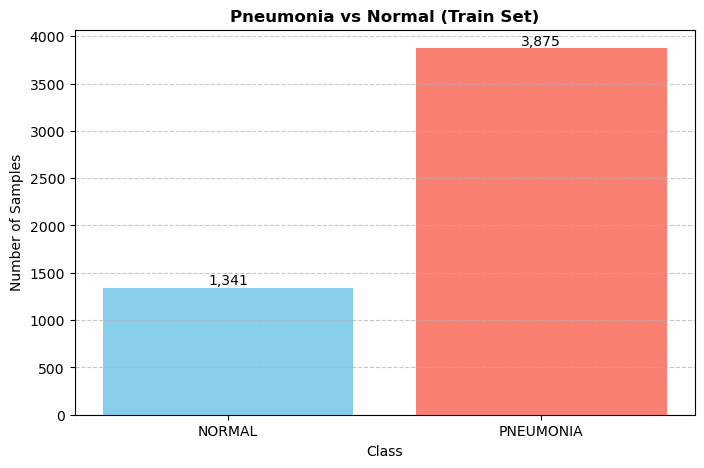

In [ ]:

import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(dataset, class_names=None, colors=None, title="Label Distribution"):
    """
    Plots the distribution of labels in a PyTorch Dataset.
    
    Args:
        dataset: PyTorch Dataset (assumes (image, label) structure).
        class_names: List of class names (e.g., ['NORMAL', 'PNEUMONIA']).
        colors: List of colors for bars (e.g., ["skyblue", "salmon"]).
        title: Plot title.
    """
    # Extract labels
    labels = [label.item() for _, label in dataset]
    
    # Count label frequencies
    label_counts = Counter(labels)
    
    # Defaults
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(label_counts))]
    if colors is None:
        colors = plt.cm.tab10.colors[:len(class_names)]  # Use matplotlib's default colors
    
    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_names, [label_counts[i] for i in range(len(class_names))], color=colors)
    
    # Add counts on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,}',
                 ha='center', va='bottom')
    
    plt.title(title, fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Use:
plot_label_distribution(
    train_dataset,
    class_names=['NORMAL', 'PNEUMONIA'],
    colors=["skyblue", "salmon"],
    title="Pneumonia vs Normal (Train Set)"
)

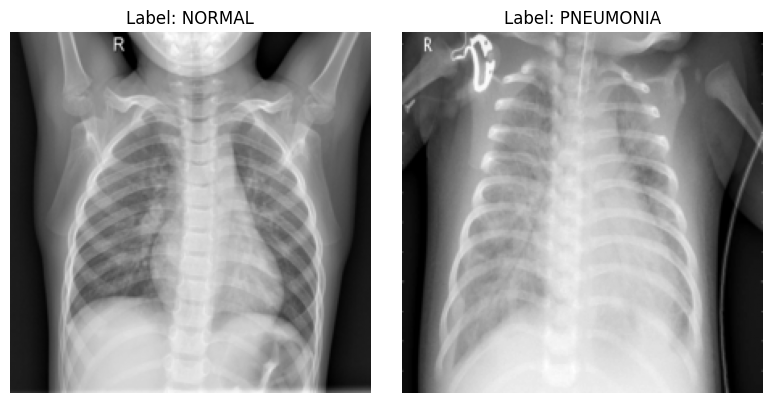

<Figure size 640x480 with 0 Axes>

In [55]:
import torch

def get_one_sample_per_class(dataset):
    label_set = set()
    for _, label in dataset:
        # handle Tensor labels
        lbl = int(label.item()) if isinstance(label, torch.Tensor) else int(label)
        label_set.add(lbl)
    num_classes = len(label_set)

    # 2) Second pass: pick the first occurrence of each label
    samples = {}
    for img, label in dataset:
        lbl = int(label.item()) if isinstance(label, torch.Tensor) else int(label)
        if lbl not in samples:
            samples[lbl] = img
        if len(samples) == num_classes:
            break

    return samples

# Define a simple label→name mapping
label_map = {
    0: "NORMAL",
    1: "PNEUMONIA",
}

# Extract one sample per class
samples = get_one_sample_per_class(train_dataset)

# Plot the images
fig, axes = plt.subplots(1, len(samples), figsize=(8, 4))
for i, label in enumerate(sorted(samples.keys())):
    img = samples[label]
    # if single-channel, squeeze to [H,W]
    arr = img.squeeze(0).cpu().numpy()
    axes[i].imshow(arr, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label_map[label]}")
plt.tight_layout()
plt.show()

plt.suptitle("One Sample per Class")
plt.tight_layout()
plt.show()


# Q1.2 - Visual Differences

In the case of NORMAL lungs, the lungs appear clear and distinguishable. PNEUMONIA, instead, shows cloudy lungs and not completely visbile, indicating a possible fluid or injection.

---

# Q1.3 - Potential Source of Bias

One great problem could be that the model learns to classify samples by looking at scanner-specific artifacts. Also, in this case we have some class imbalanceness, since the PNEUMONIA samples are more than 2x the samples of NORMAL lungs.

---

# Q1.4

The data is already transformed when loaded inside the datasets, see before for the trasformation used
---

# Q2 - CNN Classifier

## Q2.1 - Simple CNN

In [56]:
# Simple CNN Model
import torch.nn.functional as F
import torch.nn as nn
import torch

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # input is grayscale (1 channel)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # Binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Q2.2 - Performance of Test Set

It's not clear, should I train it first? Or is it zero-shot classification?

## Train the model

In [ ]:
from proj2.part2.training import train_CNN, eval_CNN

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_CNN(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, run_name= "simple_cnn")

## Now do the evaluation

In [57]:
from proj2.config import PROJ_ROOT
from proj2.part2.training import eval_CNN
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
# Evaluate the model
eval_CNN(model, test_loader, device=device)

Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]


✅ Test Set Performance:
  Test Loss       = 1.7799
  AUROC           = 0.9051
  AUPRC           = 0.9128
  Accuracy        = 0.7596
  Precision       = 0.7230
  Recall          = 0.9974
  F1 Score        = 0.8384
  Confusion Matrix:
[[ 85 149]
 [  1 389]]


{'AUROC': 0.9051446416831033,
 'AUPRC': 0.9128175933938426,
 'Accuracy': 0.7596153846153846,
 'Precision': 0.7230483271375465,
 'Recall': 0.9974358974358974,
 'F1 Score': 0.8383620689655172,
 'Confusion Matrix': array([[ 85, 149],
        [  1, 389]], dtype=int64),
 'Test Loss': 1.7798920562708633}

---
# Q3 - Integrated Gradients

Attrib:   0%|          | 0/10 [00:00<?, ?it/s]

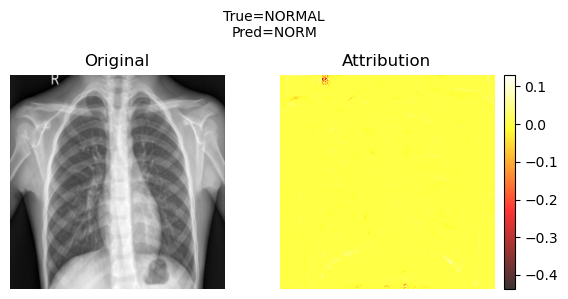

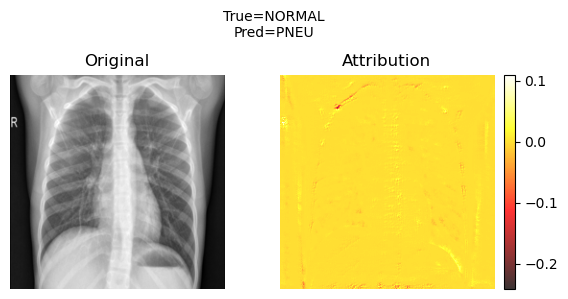

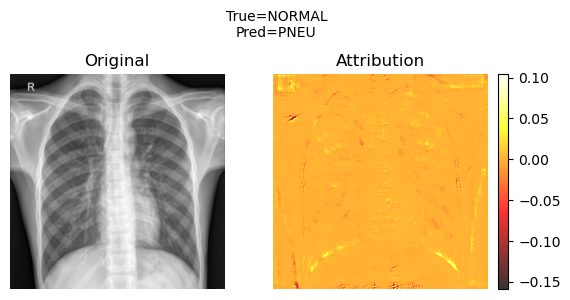

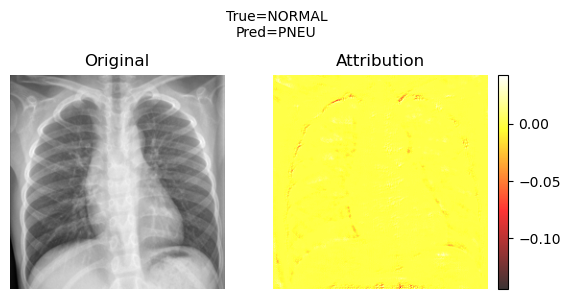

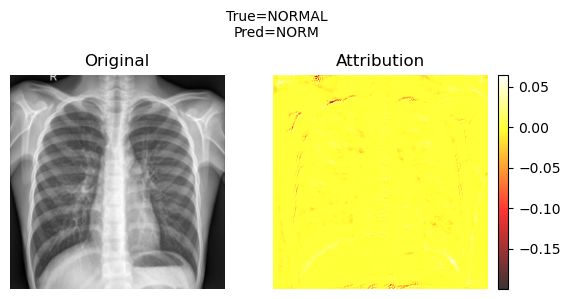

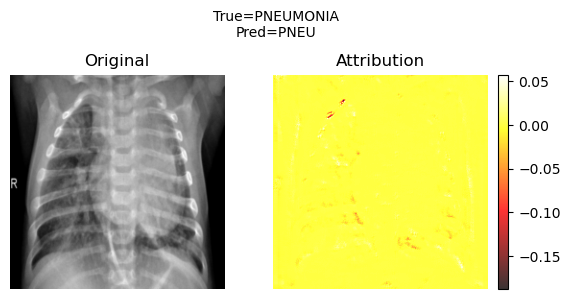

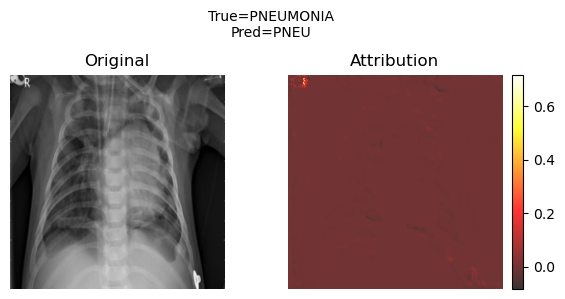

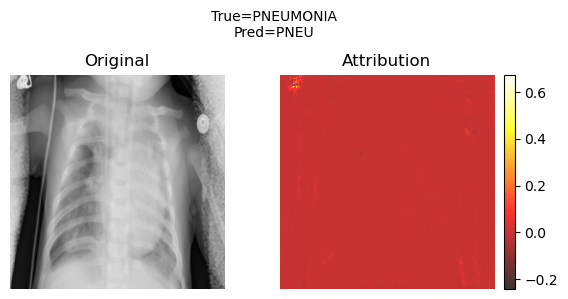

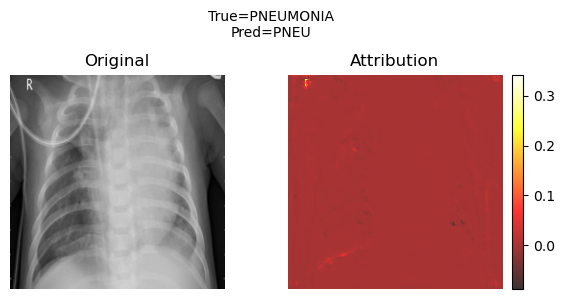

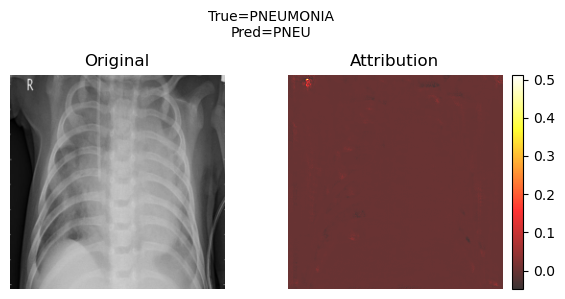

In [22]:
from captum.attr import IntegratedGradients
from torch.utils.data import Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# 2. Set up Integrated Gradients
ig = IntegratedGradients(model)

# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# 3. Helper to visualize attribution
def show_attr(attr, orig_img, title=None, save_path=None):
    """
    attr: numpy [1,224,224], orig_img: numpy [224,224]
    """
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    # original
    axes[0].imshow(orig_img, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title("Original")
    # heatmap
    im = axes[1].imshow(attr, cmap="hot", alpha=0.8)
    axes[1].axis("off")
    axes[1].set_title("Attribution")
    fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

FIG_DIR = PROJ_ROOT / "reports" / "figures"

# 4. Compute and plot
for idx, (img, lbl) in enumerate(tqdm(loader, desc="Attrib")):
    img = img.to(device)                      # [1,1,224,224]
    lbl = lbl.item()
    # Compute Integrated Gradients wrt the predicted class
    img.requires_grad_()
    pred = model(img)
    pred_class = torch.sigmoid(pred).item() >= 0.5
    target = int(pred_class)                  # use model’s own decision
    attributions, delta = ig.attribute(
            img,
            baselines=img * 0,
            target=0,              # ← must be zero for a single-output model
            n_steps=50,
            return_convergence_delta=True
        )

    # convert to CPU numpy
    attr = attributions.cpu().detach().numpy()[0,0]
    original = img.cpu().detach().numpy()[0,0]
    label_map = {0: "NORMAL", 1: "PNEUMONIA"}
    cls_name = label_map[lbl]
    title = f"True={cls_name}\nPred={'PNEU' if pred_class else 'NORM'}"
    pred_name = "PNEU" if pred_class else "NORM"

    # build a filename like "03_NORMAL_pred-PNEU.png"
    fname = f"{idx:02d}_{cls_name}_pred-{pred_name}.png"
    save_path = FIG_DIR / fname

    show_attr(attr, original, title=title, save_path=save_path)

### Now I am going to use different baselines (Add them in the Appendix)

Attribution:   0%|          | 0/10 [00:00<?, ?it/s]

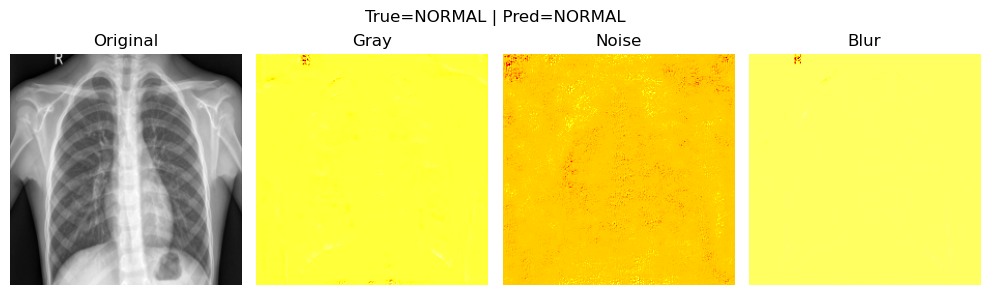

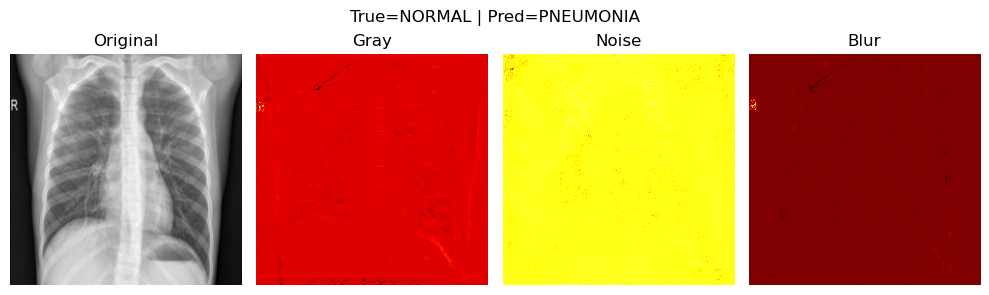

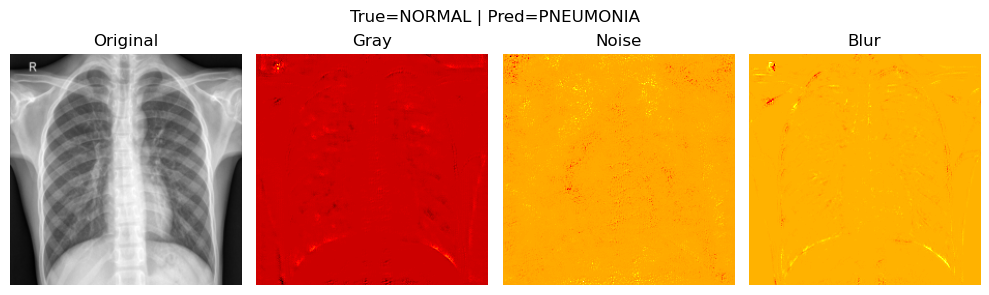

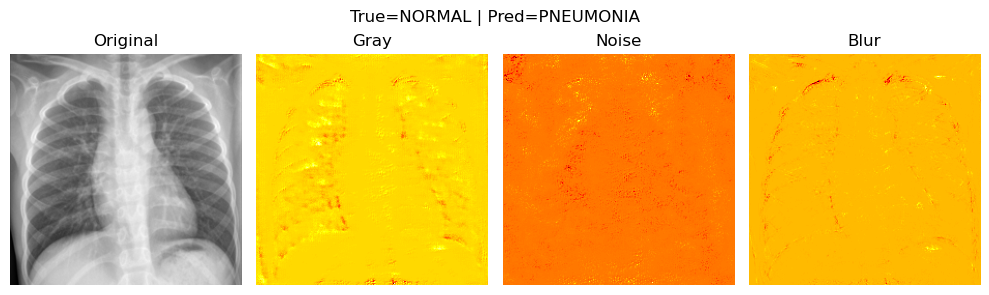

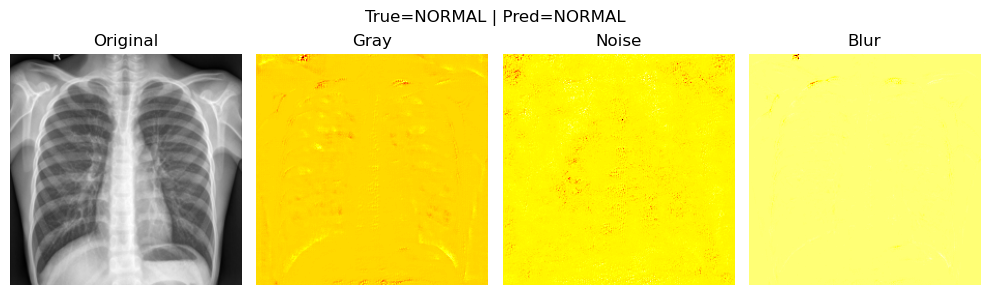

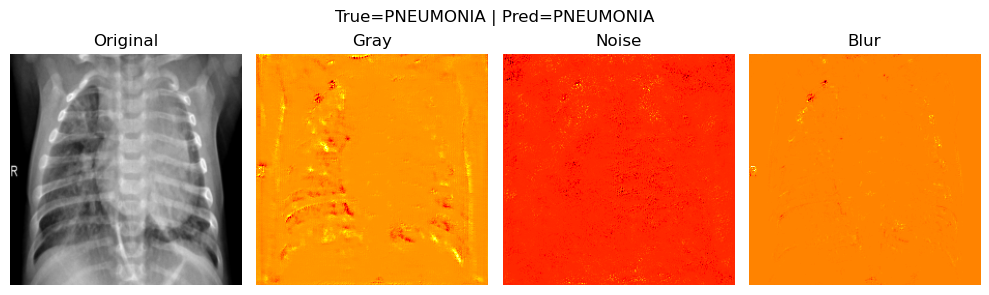

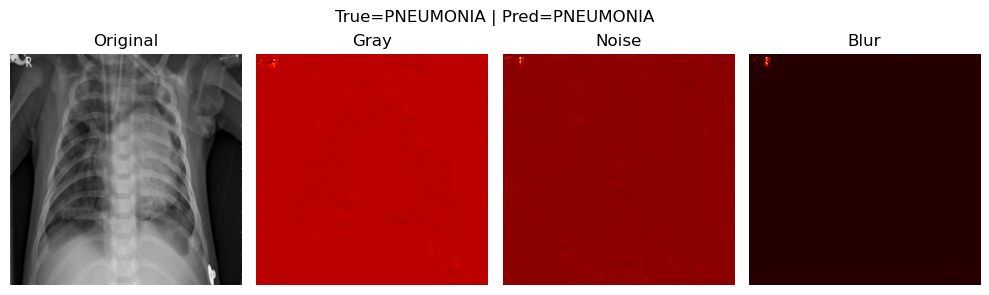

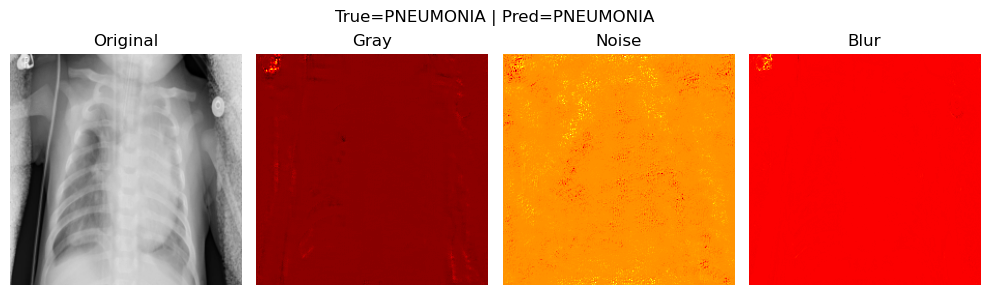

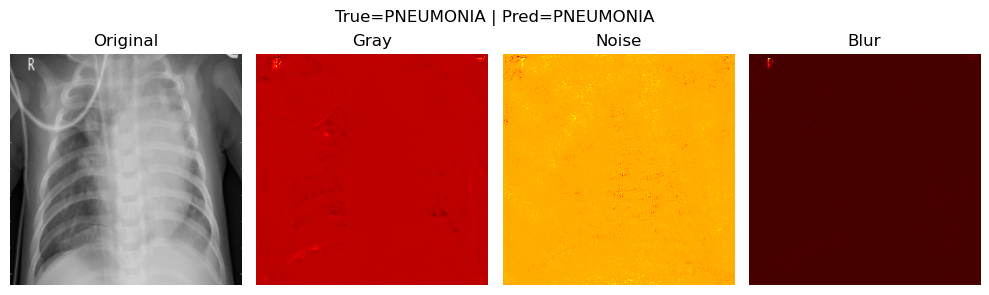

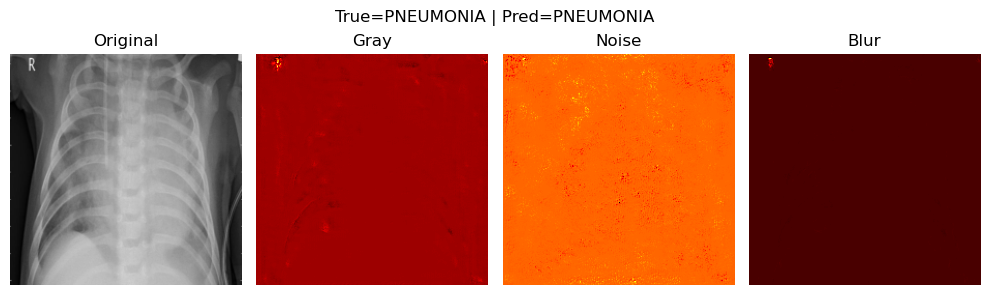

In [23]:
from captum.attr import IntegratedGradients
from torch.utils.data import Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import GaussianBlur

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# Integrated Gradients
ig = IntegratedGradients(model)

# Select samples
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl == 0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl == 1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# Baselines
BASELINES = [
    lambda img: torch.ones_like(img) * 0.5,  # Gray
    lambda img: torch.randn_like(img) * torch.std(img) + torch.mean(img),  # Random noise
    lambda img: GaussianBlur(kernel_size=5)(img)  # Blurry
]
BASELINE_NAMES = ["Gray", "Noise", "Blur"]

# Save path
FIG_DIR = PROJ_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Visualization helper
def show_multiple_attrs(original, attr_list, names, title, save_path=None):
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    for i, (attr, name) in enumerate(zip(attr_list, names), start=1):
        axes[i].imshow(attr, cmap='hot')
        axes[i].set_title(name)
        axes[i].axis("off")
    
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

# Compute and plot
label_map = {0: "NORMAL", 1: "PNEUMONIA"}
for idx, (img, lbl) in enumerate(tqdm(loader, desc="Attribution")):
    img = img.to(device)
    img.requires_grad_()
    lbl = lbl.item()
    
    pred = model(img)
    pred_class = torch.sigmoid(pred).item() >= 0.5
    target = 0

    original = img.cpu().detach().numpy()[0, 0]
    cls_name = label_map[lbl]
    pred_name = "PNEUMONIA" if pred_class else "NORMAL"
    title = f"True={cls_name} | Pred={pred_name}"
    
    attr_list = []
    for baseline_func in BASELINES:
        baseline = baseline_func(img).to(device)
        attr, _ = ig.attribute(img, baselines=baseline, target=target, n_steps=50, return_convergence_delta=True)
        attr_list.append(attr.cpu().detach().numpy()[0, 0])
    
    save_path = FIG_DIR / f"{idx:02d}_{cls_name}_pred-{pred_name}_multi-baseline.png"
    show_multiple_attrs(original, attr_list, BASELINE_NAMES, title, save_path=save_path)


### Comment on Integrated Gradients:

The brightest colors (white/yellow) indicate that the area has been very relevant in predicting the outcome (PNEUMONIA). Dark colors indicate that they were contributing negatively (push to the other class, NORMAL).

### Save added
Three new baselines (grey, random noise, blurred) and also I think the comment is not correct: I would say more:

The attribution maps  reveal decision-influencing regions through a heatmap where yellow/white indicates areas increasing pneumonia probability while darker regions suggest normal evidence. For pneumonia predictions, bright zones clearly indicate diagnostic features, whereas normal predictions show competing evidence - with pneumonia-like patterns (bright) being outweighed by less visually prominent normal indicators (dark). The visualization reflects attributions computed against the model's single output logit, where positive values push toward pneumonia classification and negative values toward normal.

---

## Q3.2 - Do the maps highlight sensible regions?

Yes, the attribution maps generally highlight clinically relevant regions of the lungs. In samples labeled PNEUMONIA, high-attribution areas often appear around localized cloudy regions or infiltrates, which is consistent with where abnormalities manifest. For NORMAL cases, the attributions are more evenly distributed or focus on the lung outlines and areas free of occlusions.

---

## Q3.3 — Are attributions consistent across samples?

Mostly yes. Across different PNEUMONIA samples, attribution maps consistently highlight patchy, high-opacity regions, even though their locations vary (left vs. right lung, upper vs. lower lobes). For NORMAL cases, the attributions tend to focus on central lung zones and edges, which are structurally stable across patients.

However, small variations can occur depending on pose, cropping, or scanner noise. These are expected in medical images, and the general pattern of focusing on lung areas is preserved.

---

## Q3.4 — Does the choice of baseline input image have a big effect on the attribution maps?

I'd say not that big

---

# Q4 - Grad-CAM

In [29]:
# 1) Define a GradCAM helper
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients   = None

        # register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out is a tuple; we want the gradients wrt the layer's output
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_index):
        """
        input_tensor: shape [1, C, H, W]
        target_index: index of the logit to explain (0 for single-output)
        """
        self.model.zero_grad()
        output = self.model(input_tensor)             # forward
        # If single-output, output is shape [1,1]; pick [0,0]
        score  = output[0, target_index]              # scalar logit
        score.backward(retain_graph=True)             # backward

        # pull out the saved activations + gradients
        activations = self.activations[0]              # [K, h, w]
        gradients   = self.gradients[0]                # [K, h, w]

        # global-average-pool the gradients into weights
        weights = gradients.mean(dim=(1,2))            # [K]

        # linear combination of weights * activations
        cam = torch.zeros_like(activations[0])
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)                          # remove negatives
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)                 # normalize to [0,1]

        # upsample to input size
        cam = cam.unsqueeze(0).unsqueeze(0)            # [1,1,h,w]
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        )[0,0]                                        # [H,W]
        return cam.cpu().numpy()

In [30]:
# 2) Prepare model & data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
checkpoint = torch.load(PROJ_ROOT/"models"/"cnn"/"simple_cnn_model_final.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [31]:
# choose the last conv layer in SimpleCNN.features
target_layer = model.features[6]  # the third Conv2d
gradcam = GradCAM(model, target_layer)

In [32]:
# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl==1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

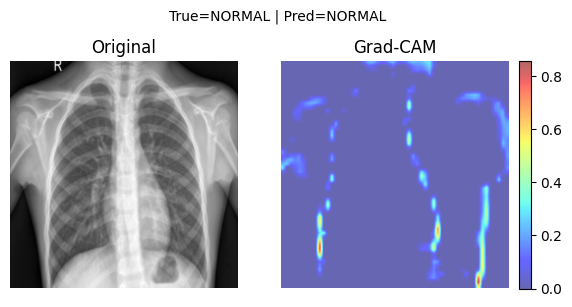

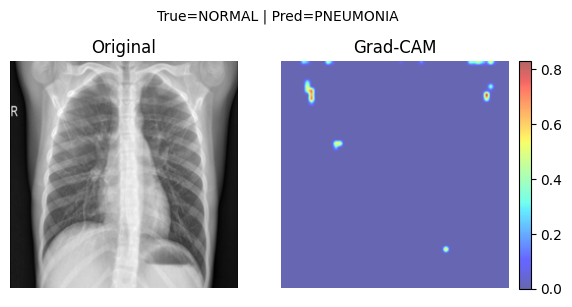

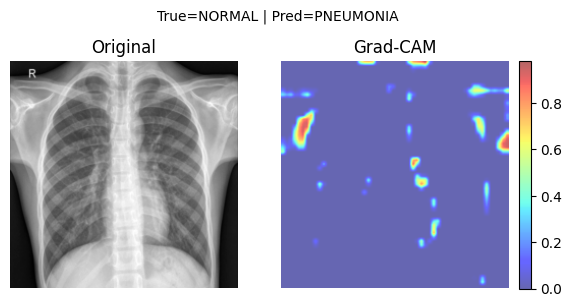

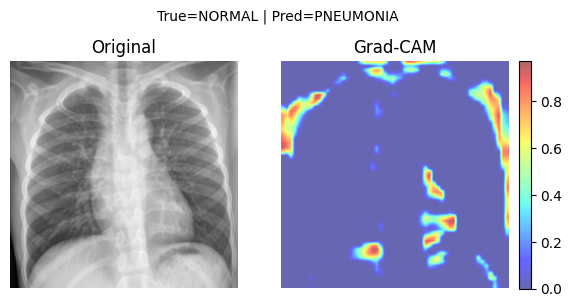

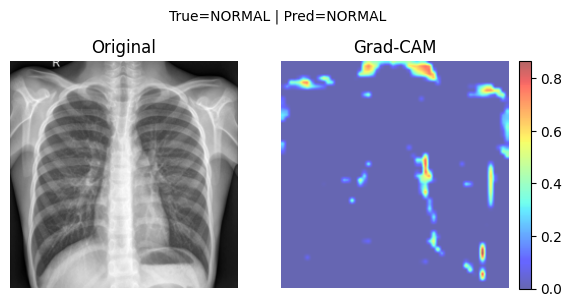

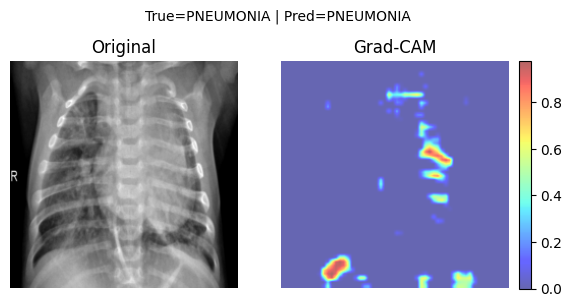

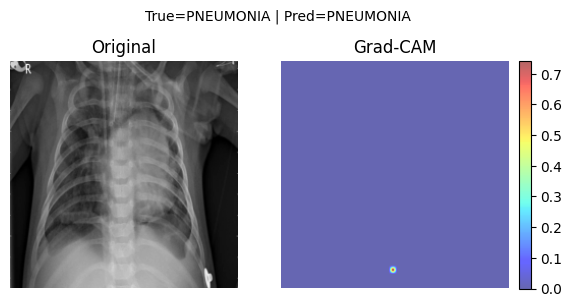

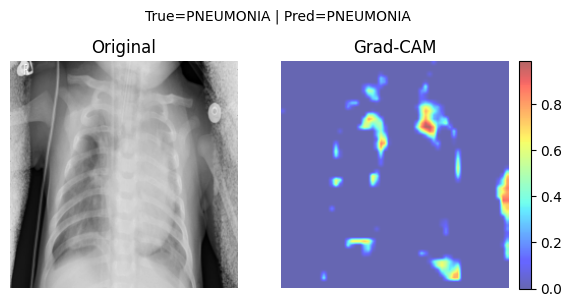

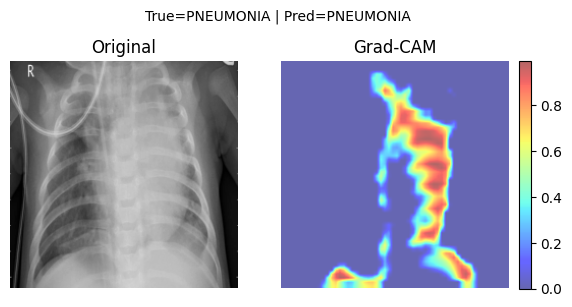

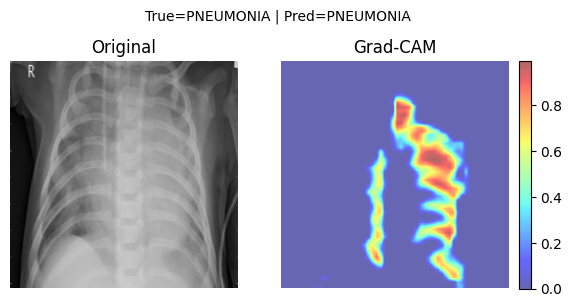

In [33]:
FIG_DIR = PROJ_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 3) Visualization helper
def show_gradcam(cam, orig, title=None, save_path=None):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
    ax1.imshow(orig, cmap="gray")
    ax1.axis("off"); ax1.set_title("Original")
    im = ax2.imshow(cam, cmap="jet", alpha=0.6)
    ax2.axis("off"); ax2.set_title("Grad‑CAM")
    if title: fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


# 4) Compute & plot
label_map = {0:"NORMAL",1:"PNEUMONIA"}
for idx, (img, lbl) in enumerate(loader):
    img = img.to(device)
    lbl = lbl.item()
    # forward to get predicted class
    logit = model(img)
    pred = (torch.sigmoid(logit) >= 0.5).long().item()

    # compute GradCAM heatmap
    cam = gradcam.generate(img, target_index=0)

    # undo normalization for visualization
    inv = img.cpu().squeeze(0).squeeze(0).numpy()
    inv = inv*0.5 + 0.5  # back to [0,1] range

    title = f"True={label_map[lbl]} | Pred={label_map[pred]}"
    true_label = label_map[lbl]
    pred_label = label_map[pred]
    fname = f"{idx:02d}_{true_label}_pred-{pred_label}_gradcam.png"
    save_path = FIG_DIR / fname
    show_gradcam(cam, inv, title=title, save_path=save_path)

## Comprehensive table for the report

In [ ]:
import matplotlib.pyplot as plt

# Raccolta immagini e titoli
originals = []
igs = []
gradcams = []
titles = []

# Ricarichiamo i dati
idx_norm = [i for i, (_, lbl) in enumerate(test_dataset) if lbl == 0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_dataset) if lbl == 1][:5]
subset = Subset(test_dataset, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# IG e GradCAM
ig = IntegratedGradients(model)
gradcam = GradCAM(model, model.features[6])

label_map = {0: "NORMAL", 1: "PNEUMONIA"}

# Popoliamo le liste
for idx, (img, lbl) in enumerate(tqdm(loader, desc="Preparing table")):
    img = img.to(device)
    lbl = lbl.item()
    
    logit = model(img)
    pred_class = (torch.sigmoid(logit) >= 0.5).long().item()

    cls_name = label_map[lbl]
    pred_name = "PNEUMONIA" if pred_class else "NORMAL"   # <--- qui correggiamo
    title = f"True={cls_name}\nPred={pred_name}"          # <--- corretto
    titles.append(title)

    inv = img.cpu().squeeze(0).squeeze(0).numpy()
    inv = inv * 0.5 + 0.5
    originals.append(inv)

    img.requires_grad_()
    attr_ig, delta = ig.attribute(
        img,
        baselines=img * 0,
        target=0,
        n_steps=50,
        return_convergence_delta=True
    )
    attr_ig = attr_ig.cpu().detach().numpy()[0, 0]
    igs.append(attr_ig)

    cam = gradcam.generate(img, target_index=0)
    gradcams.append(cam)

# Ora creiamo la figura
fig, axes = plt.subplots(len(originals), 3, figsize=(15, 30))

for row in range(len(originals)):
    axes[row, 0].imshow(originals[row], cmap="gray")
    axes[row, 0].axis("off")
    if row == 0:
        axes[row, 0].set_title("Original", fontsize=14)

    axes[row, 1].imshow(igs[row], cmap="hot", alpha=0.8)
    axes[row, 1].axis("off")
    if row == 0:
        axes[row, 1].set_title("Integrated Gradients", fontsize=14)

    axes[row, 2].imshow(gradcams[row], cmap="jet", alpha=0.6)
    axes[row, 2].axis("off")
    if row == 0:
        axes[row, 2].set_title("Grad-CAM", fontsize=14)

# Aggiungiamo i titoli a sinistra
for i, title in enumerate(titles):
    fig.text(0.26, (len(titles)-i-0.5)/len(titles), title,
             ha='right', va='center', fontsize=14)  # <-- più grande e più a destra

plt.tight_layout()
plt.subplots_adjust(left=0.25)  # ancora più spazio per titoli grandi
BIG_TABLE_PATH = FIG_DIR / "big_table.png"

plt.savefig(BIG_TABLE_PATH, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved big table at {BIG_TABLE_PATH}")


### Comment on GradCAM

Grad-CAM highlights which regions in the image influenced the model’s prediction the most. The color intensity in the heatmap reflects the importance of each spatial region:
- Red/Yellow (Hot) → High contribution: these areas strongly influenced the model toward its predicted class.
- Blue/Dark → Low contribution: these areas had little or no impact on the model’s decision.

In practice, we expect:
- PNEUMONIA cases to show red/yellow highlights over cloudy or inflamed lung regions.
- NORMAL cases to show more diffuse or empty activations across the lung fields.

---

## Q4.2 - Do the maps highlight sensible regions?

Yes.
Grad-CAM maps consistently highlight lung regions, especially areas where the model likely detects abnormalities. In PNEUMONIA samples, high-activation zones appear over cloudy or patchy textures, which correspond to infection or fluid buildup. In NORMAL samples, the activation is either spread more evenly or focused around anatomically relevant structures, such as lung boundaries or central chest regions.

🖼️ Figure Suggestion: Include 1–2 side-by-side examples showing original vs. Grad-CAM overlay for both NORMAL and PNEUMONIA cases.

---

## Q4.3 — Are attributions consistent across samples?

Mostly, yes.
Across PNEUMONIA samples, Grad-CAM tends to focus on localized areas of increased opacity—regardless of where in the lungs they occur (left/right, upper/lower lobes). NORMAL cases exhibit more distributed or less intense activation, showing that the model relies on broader context in the absence of disease.

This consistency suggests that the model is learning a reliable spatial pattern for detecting pneumonia.

🖼️ Figure Suggestion: Show a 2×5 grid (or two rows of 5 images each) with Grad-CAM overlays for multiple NORMAL and PNEUMONIA test samples.

---

## Q4.4 — Compare your findings with Q3

Grad-CAM and Integrated Gradients (IG) offer complementary insights into model behavior. Grad-CAM produces coarse, region-level heatmaps that highlight where the model is focusing its attention, typically aligning with semantically meaningful areas like lung regions with visible opacity. In contrast, IG provides fine-grained, pixel-level attributions that reveal which specific pixels contribute most to the prediction. Grad-CAM is generally more interpretable and stable across samples, making it well-suited for visual explanations in medical imaging. IG, while more sensitive to subtle variations, is dependent on the choice of baseline, which can influence the results significantly. Overall, Grad-CAM excels in providing a high-level overview of spatial attention, while IG is more informative for understanding low-level pixel interactions. Using both methods together can provide a deeper understanding of model decisions.

---

# Q5 - Data Randomization Test

## Q5.1 - Train CNN on Random Training Labels

In [35]:
from proj2.config import PROJ_ROOT
from proj2.part2.dataloader import get_data_set_loader
from proj2.part2.training import train_CNN, eval_CNN
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_data_set_loader(
    image_size=(224,224), batch_size=32
)

images_tensor, labels_tensor = train_ds.tensors


Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5216
Val   samples: 16
Test  samples: 624


In [ ]:

# Shuffle the labels
perm = torch.randperm(len(labels_tensor))
random_labels = labels_tensor[perm]

# Create a new dataset with the permuted labels
random_train_ds = TensorDataset(images_tensor, random_labels)
random_train_loader = DataLoader(random_train_ds, batch_size=32, shuffle=True)

# Instantiate a fresh model & optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnd_model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(rnd_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# 6) Retrain on the randomly permuted labels
train_CNN(
    rnd_model,
    random_train_loader,
    val_loader,        # keep validation set with true labels (or you can skip val)
    optimizer,
    criterion,
    num_epochs=10,
    device=device,
    run_name="random_labels",
)

## Q5.2 - Perform the Data Randomization Test

Attrib:   0%|          | 0/10 [00:00<?, ?it/s]

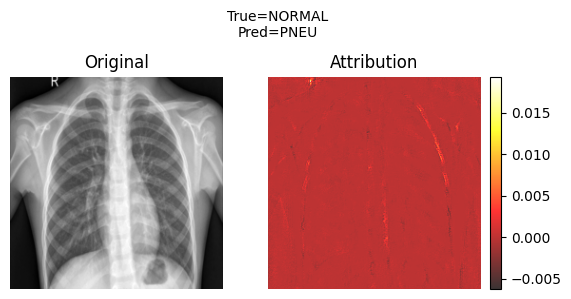

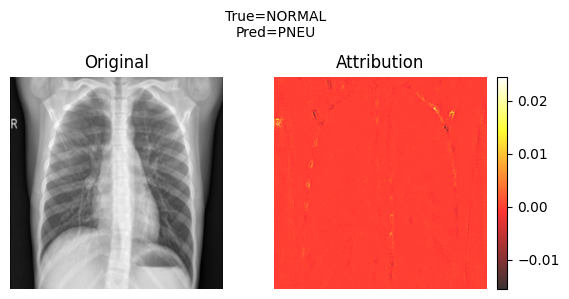

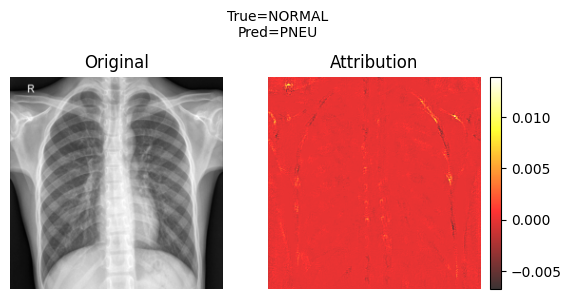

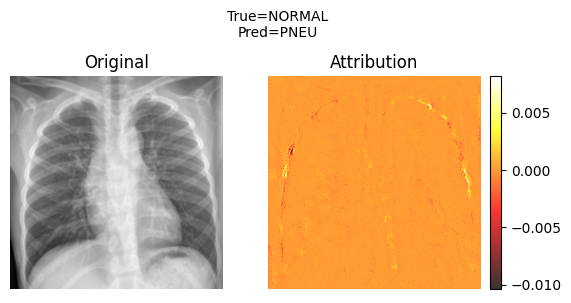

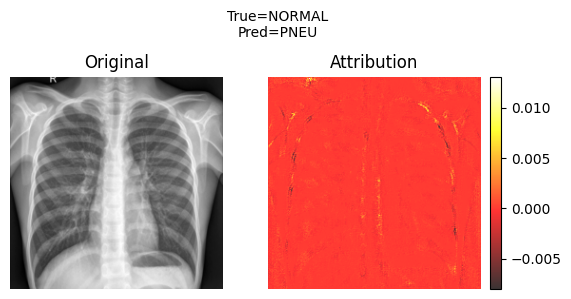

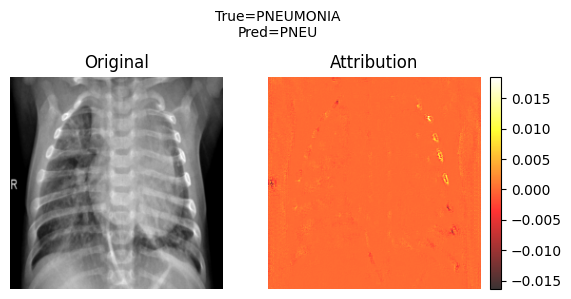

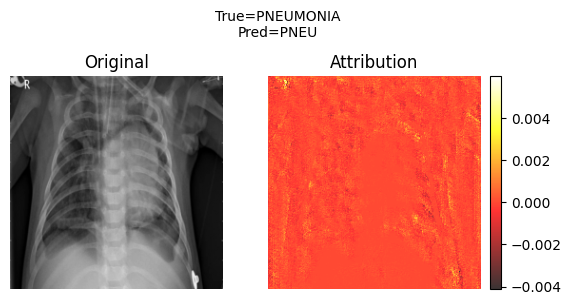

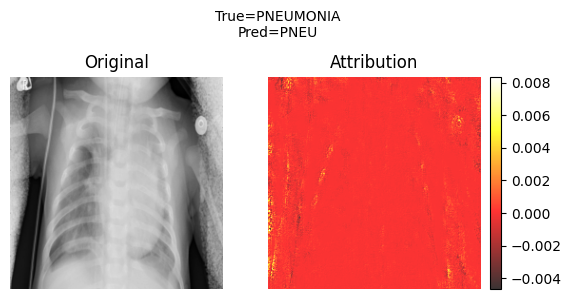

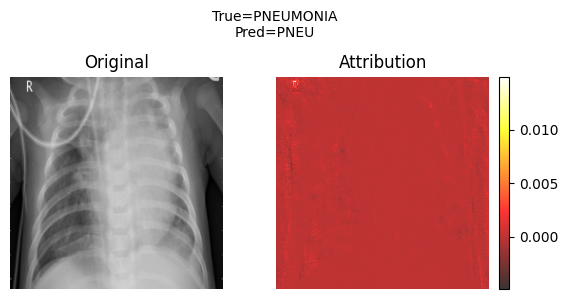

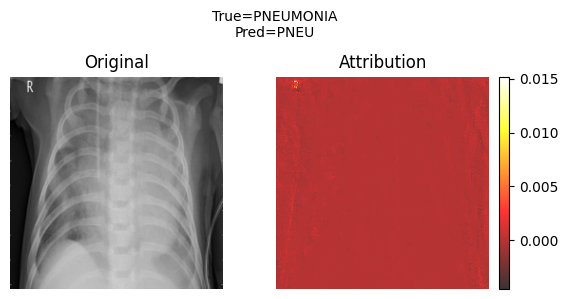

In [38]:
from captum.attr import IntegratedGradients
from torch.utils.data import Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "random_labels_model_final.pt"
rnd_model = SimpleCNN().to(device)
rnd_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
rnd_model.eval()

# 2. Set up Integrated Gradients
ig = IntegratedGradients(rnd_model)

# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_ds) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_ds) if lbl==1][:5]
subset = Subset(test_ds, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# 3. Helper to visualize attribution
def show_attr(attr, orig_img, title=None, save_path=None):
    """
    attr: numpy [1,224,224], orig_img: numpy [224,224]
    """
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    # original
    axes[0].imshow(orig_img, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title("Original")
    # heatmap
    im = axes[1].imshow(attr, cmap="hot", alpha=0.8)
    axes[1].axis("off")
    axes[1].set_title("Attribution")
    fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

# 4. Compute and plot
for idx, (img, lbl) in enumerate(tqdm(loader, desc="Attrib")):
    img = img.to(device)                      # [1,1,224,224]
    lbl = lbl.item()
    # Compute Integrated Gradients wrt the predicted class
    img.requires_grad_()
    pred = rnd_model(img)
    pred_class = torch.sigmoid(pred).item() >= 0.5
    target = int(pred_class)                  # use model’s own decision
    attributions, delta = ig.attribute(
        img,
        baselines=img * 0,
        target=0,              # ← must be zero for a single-output model
        n_steps=50,
        return_convergence_delta=True
    )
    # convert to CPU numpy
    attr = attributions.cpu().detach().numpy()[0,0]
    original = img.cpu().detach().numpy()[0,0]
    label_map = {0: "NORMAL", 1: "PNEUMONIA"}
    cls_name = label_map[lbl]
    title = f"True={cls_name}\nPred={'PNEU' if pred_class else 'NORM'}"
    pred_name = "PNEU" if pred_class else "NORM"

    # build a filename like "03_NORMAL_pred-PNEU.png"
    fname = f"{idx:02d}_random_model_{cls_name}_pred-{pred_name}.png"
    save_path = FIG_DIR / fname

    show_attr(attr, original, title=title, save_path=save_path)

### Test the random trained CNN with GradCAM

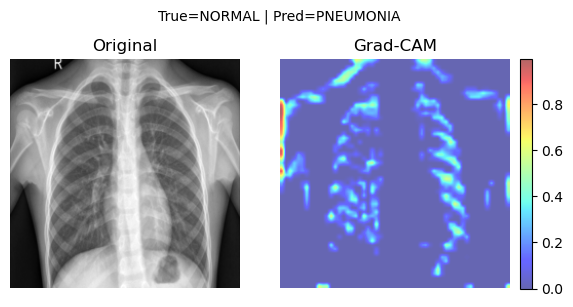

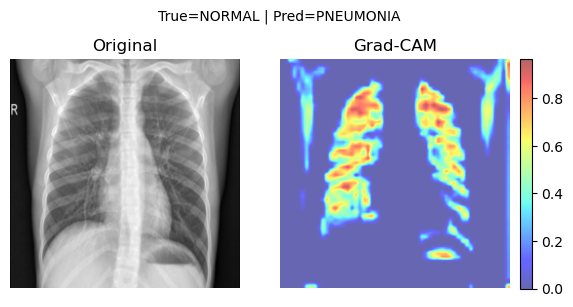

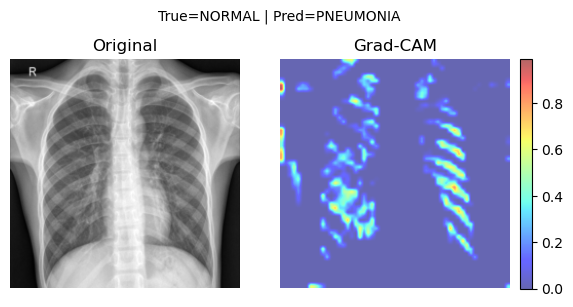

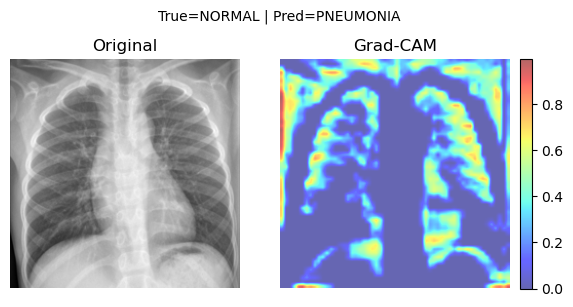

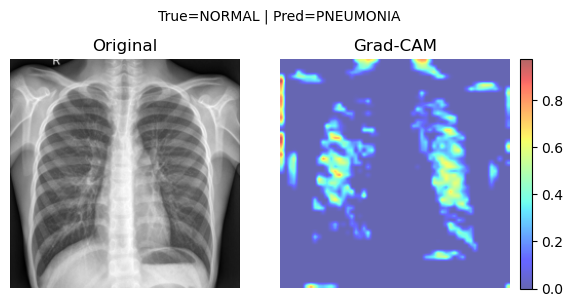

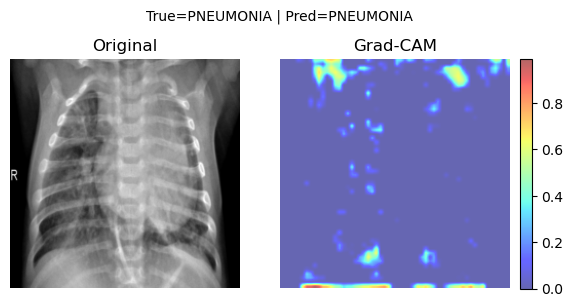

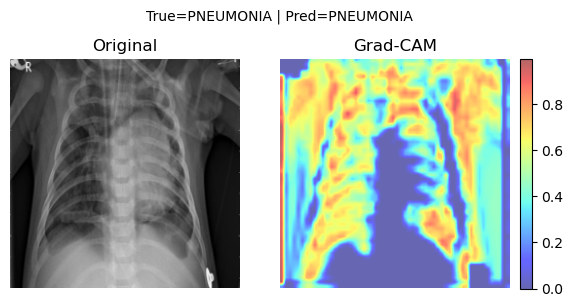

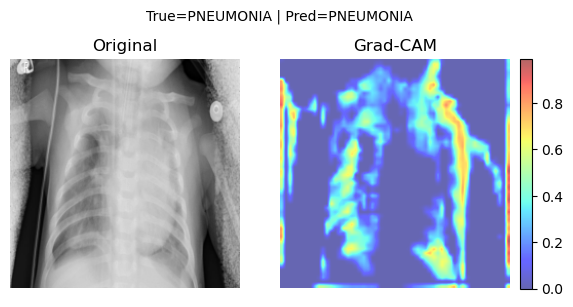

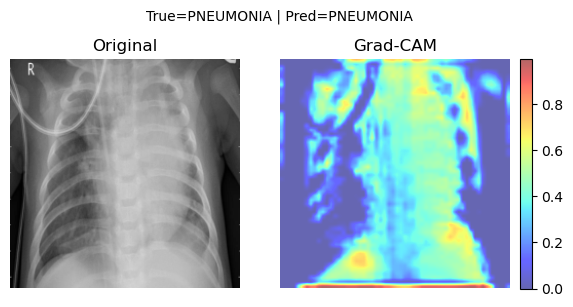

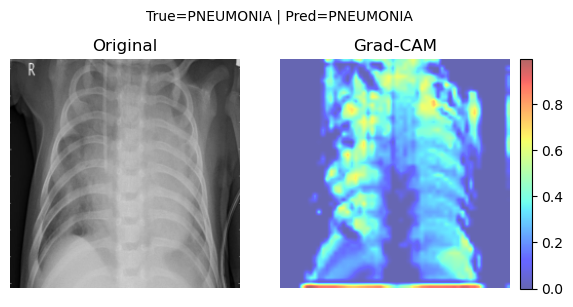

In [34]:
# Now use Integrated Gradients and GradCAM on the random model
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# GRADCAM
# choose the last conv layer in SimpleCNN.features
target_layer = rnd_model.features[6]  # the third Conv2d
gradcam = GradCAM(rnd_model, target_layer)

# Pick 5 normals (label=0) and 5 pneumonia (label=1)
idx_norm = [i for i, (_, lbl) in enumerate(test_ds) if lbl==0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_ds) if lbl==1][:5]
subset = Subset(test_ds, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

FIG_DIR = PROJ_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 3) Visualization helper
def show_gradcam(cam, orig, title=None, save_path=None):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
    ax1.imshow(orig, cmap="gray")
    ax1.axis("off"); ax1.set_title("Original")
    im = ax2.imshow(cam, cmap="jet", alpha=0.6)
    ax2.axis("off"); ax2.set_title("Grad‑CAM")
    if title: fig.suptitle(title, fontsize=10)
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


# 4) Compute & plot
label_map = {0:"NORMAL",1:"PNEUMONIA"}
for idx, (img, lbl) in enumerate(loader):
    img = img.to(device)
    lbl = lbl.item()
    # forward to get predicted class
    logit = rnd_model(img)
    pred = (torch.sigmoid(logit) >= 0.5).long().item()

    # compute GradCAM heatmap
    cam = gradcam.generate(img, target_index=0)

    # undo normalization for visualization
    inv = img.cpu().squeeze(0).squeeze(0).numpy()
    inv = inv*0.5 + 0.5  # back to [0,1] range

    title = f"True={label_map[lbl]} | Pred={label_map[pred]}"
    true_label = label_map[lbl]
    pred_label = label_map[pred]
    fname = f"{idx:02d}_random_model_{true_label}_pred-{pred_label}_gradcam.png"
    save_path = FIG_DIR / fname
    show_gradcam(cam, inv, title=title, save_path=save_path)

### Compare Normal Model with Randomized Model (first with Integrated Gradients)

Added Spearman correlation 

Processing sample 0 (label: Normal)
 → Spearman ABS: 0.3198, Diverging: -0.0024


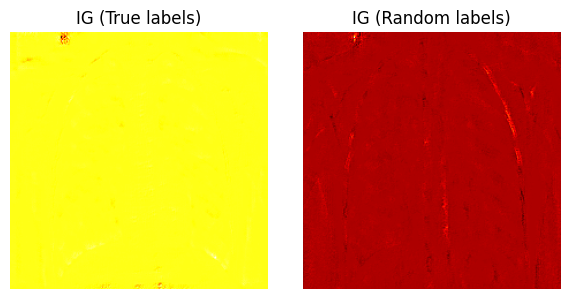

Processing sample 1 (label: Normal)
 → Spearman ABS: 0.3503, Diverging: 0.0094


<Figure size 640x480 with 0 Axes>

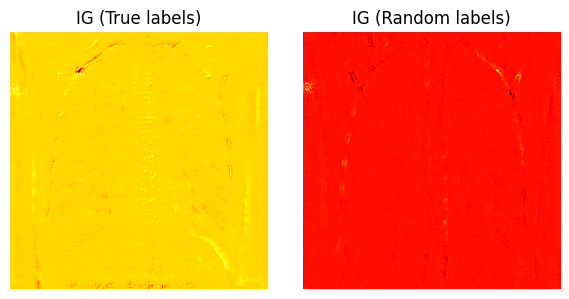

Processing sample 2 (label: Normal)
 → Spearman ABS: 0.3386, Diverging: 0.0051


<Figure size 640x480 with 0 Axes>

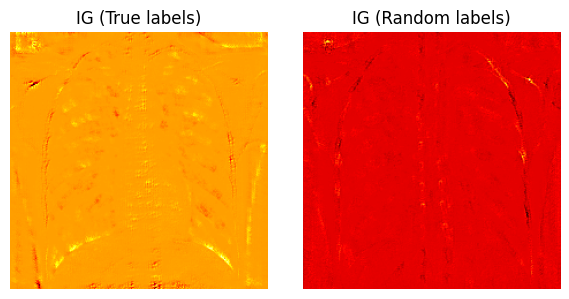

Processing sample 3 (label: Normal)
 → Spearman ABS: 0.3013, Diverging: 0.0163


<Figure size 640x480 with 0 Axes>

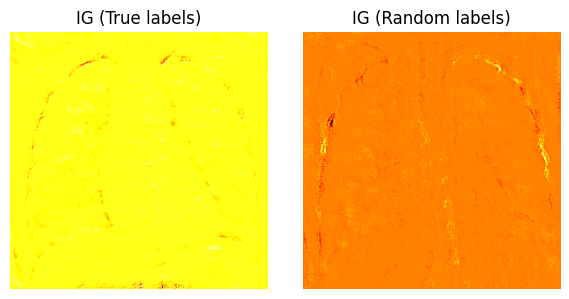

Processing sample 4 (label: Normal)
 → Spearman ABS: 0.3762, Diverging: 0.0143


<Figure size 640x480 with 0 Axes>

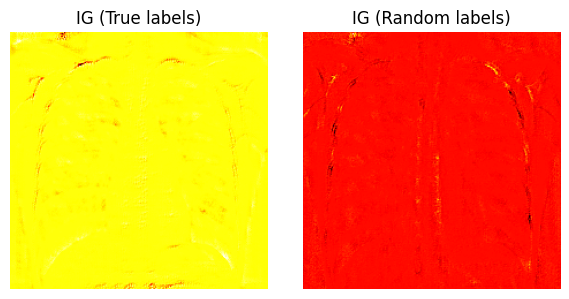

Processing sample 5 (label: Pneumonia)
 → Spearman ABS: 0.3894, Diverging: 0.0161


<Figure size 640x480 with 0 Axes>

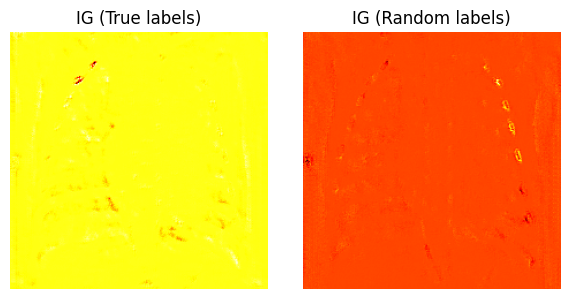

Processing sample 6 (label: Pneumonia)
 → Spearman ABS: 0.3184, Diverging: 0.0007


<Figure size 640x480 with 0 Axes>

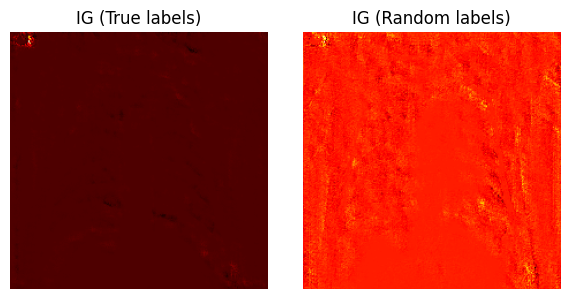

Processing sample 7 (label: Pneumonia)
 → Spearman ABS: 0.3315, Diverging: -0.0101


<Figure size 640x480 with 0 Axes>

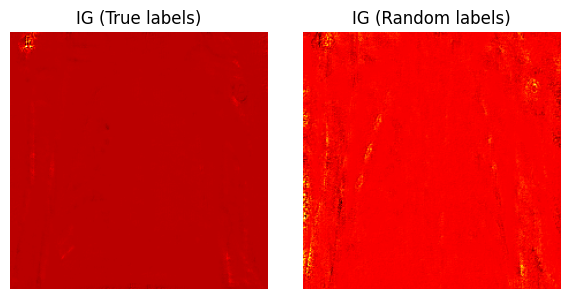

Processing sample 8 (label: Pneumonia)
 → Spearman ABS: 0.3483, Diverging: -0.0043


<Figure size 640x480 with 0 Axes>

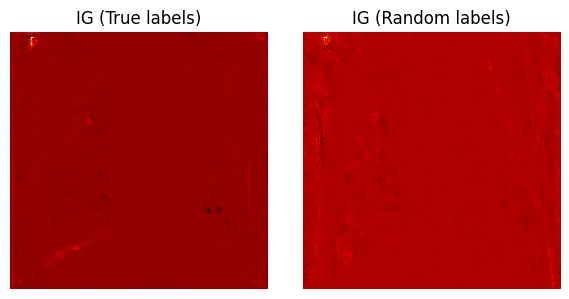

Processing sample 9 (label: Pneumonia)
 → Spearman ABS: 0.2829, Diverging: -0.0159


<Figure size 640x480 with 0 Axes>

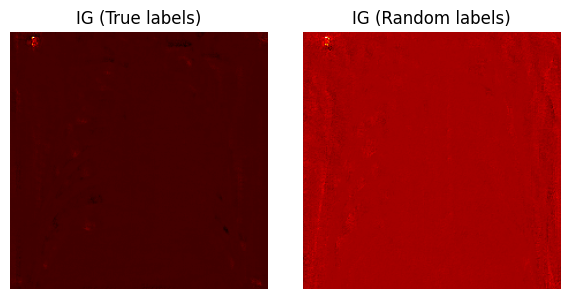


=== Average Spearman Correlation ===
Mean Spearman (ABS): 0.3357
Mean Spearman (Diverging): 0.0029


<Figure size 640x480 with 0 Axes>

In [ ]:
from captum.attr import IntegratedGradients
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import os
from scipy.stats import spearmanr

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# Load the random model
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "random_labels_model_final.pt"
rnd_model = SimpleCNN().to(device)
rnd_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
rnd_model.eval()

# Set up Integrated Gradients
ig = IntegratedGradients(model)
ig_rnd = IntegratedGradients(rnd_model)

# Select 5 normal and 5 pneumonia samples
idx_norm = [i for i, (_, lbl) in enumerate(test_ds) if lbl == 0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_ds) if lbl == 1][:5]
subset = Subset(test_ds, idx_norm + idx_pneu)
loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

# Compute IG
def compute_ig(model, ig_tool, img):
    img = img.to(device); img.requires_grad_()
    attr = ig_tool.attribute(img, baselines=img*0, target=0, n_steps=50)
    return attr.detach().cpu().numpy()[0, 0]  # shape: [H, W]

# Compute Spearman correlation
def compute_spearman(attr1, attr2, abs_val=True):
    a1 = attr1.flatten()
    a2 = attr2.flatten()
    if abs_val:
        a1 = np.abs(a1)
        a2 = np.abs(a2)
    return spearmanr(a1, a2).correlation

# Output dir
output_dir = PROJ_ROOT / "reports" / "figures" / "ig_individual_images"
os.makedirs(output_dir, exist_ok=True)

# Store correlation scores
spearman_abs_list = []
spearman_div_list = []

# Attribution loop
for i, (img, lbl) in enumerate(loader):
    print(f"Processing sample {i} (label: {'Pneumonia' if lbl.item() else 'Normal'})")
    
    # Compute IG maps
    ig_map = compute_ig(model, ig, img)
    ig_map_rnd = compute_ig(rnd_model, ig_rnd, img)

    # Spearman correlations
    corr_abs = compute_spearman(ig_map, ig_map_rnd, abs_val=True)
    corr_div = compute_spearman(ig_map, ig_map_rnd, abs_val=False)

    spearman_abs_list.append(corr_abs)
    spearman_div_list.append(corr_div)

    print(f" → Spearman ABS: {corr_abs:.4f}, Diverging: {corr_div:.4f}")

    # Plot IG maps
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, im, title in zip(axes, [ig_map, ig_map_rnd],
                             ["IG (True labels)", "IG (Random labels)"]):
        ax.imshow(im, cmap="hot")
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Save
    output_path = output_dir / f"ig_sample_{i}_label_{lbl.item()}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

# Print average Spearman correlation
print(f"\n=== Average Spearman Correlation ===")
print(f"Mean Spearman (ABS): {np.mean(spearman_abs_list):.4f}")
print(f"Mean Spearman (Diverging): {np.mean(spearman_div_list):.4f}")


Sanity check for Spearman correlation: create two identical arrays and two opposite arrays 

In [65]:
from scipy.stats import spearmanr
import numpy as np

def check_spearman_sanity():
    # 1. Identical maps
    arr1 = np.random.randn(224, 224)
    arr2 = np.copy(arr1)
    
    corr_abs = spearmanr(np.abs(arr1).flatten(), np.abs(arr2).flatten()).correlation
    corr_div = spearmanr(arr1.flatten(), arr2.flatten()).correlation

    print("Identical maps:")
    print(f"  Spearman ABS: {corr_abs:.4f} (Expected ~1.0)")
    print(f"  Spearman Diverging: {corr_div:.4f} (Expected ~1.0)")

    # 2. Opposite maps (negated)
    arr2 = -arr1
    
    corr_abs = spearmanr(np.abs(arr1).flatten(), np.abs(arr2).flatten()).correlation
    corr_div = spearmanr(arr1.flatten(), arr2.flatten()).correlation

    print("\nOpposite maps:")
    print(f"  Spearman ABS: {corr_abs:.4f} (Expected ~1.0 — ABS removes sign)")
    print(f"  Spearman Diverging: {corr_div:.4f} (Expected ~-1.0 — perfect inverse)")
    
check_spearman_sanity()


Identical maps:
  Spearman ABS: 1.0000 (Expected ~1.0)
  Spearman Diverging: 1.0000 (Expected ~1.0)

Opposite maps:
  Spearman ABS: 1.0000 (Expected ~1.0 — ABS removes sign)
  Spearman Diverging: -1.0000 (Expected ~-1.0 — perfect inverse)


Now I do it for the whole set

In [ ]:
# Create DataLoader for the full test set
loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Store correlation scores
spearman_abs_list = []
spearman_div_list = []

# Baseline vs random noise
spearman_rand_vs_trained_abs = []
spearman_rand_vs_trained_div = []


# Attribution loop for the full test set with a progress bar
for i, (img, lbl) in tqdm(enumerate(loader), total=len(loader), desc="Processing samples"):
    # Compute IG maps
    ig_map = compute_ig(model, ig, img)
    ig_map_rnd = compute_ig(rnd_model, ig_rnd, img)

    # Spearman correlations (real vs random-label)
    corr_abs = compute_spearman(ig_map, ig_map_rnd, abs_val=True)
    corr_div = compute_spearman(ig_map, ig_map_rnd, abs_val=False)
    spearman_abs_list.append(corr_abs)
    spearman_div_list.append(corr_div)

    # Generate random saliency map (Gaussian noise)
    random_map = np.random.randn(*ig_map.shape)

    # Spearman correlations vs random noise
    corr_rand_vs_trained_abs = compute_spearman(ig_map, random_map, abs_val=True)
    corr_rand_vs_trained_div = compute_spearman(ig_map, random_map, abs_val=False)
    spearman_rand_vs_trained_abs.append(corr_rand_vs_trained_abs)
    spearman_rand_vs_trained_div.append(corr_rand_vs_trained_div)

# === Final Results ===
print(f"\n=== Average Spearman Correlation (Trained vs Random-Label) ===")
print(f"Mean Spearman (ABS): {np.mean(spearman_abs_list):.4f}")
print(f"Mean Spearman (Diverging): {np.mean(spearman_div_list):.4f}")

print(f"\n=== Baseline: Trained vs Random Noise ===")
print(f"Mean Spearman (ABS): {np.nanmean(spearman_rand_vs_trained_abs):.4f}")
print(f"Mean Spearman (Diverging): {np.nanmean(spearman_rand_vs_trained_div):.4f}")

Processing samples:  14%|█▍        | 86/624 [06:31<40:47,  4.55s/it]  


KeyboardInterrupt: 

### Compare Normal Model with Randomized Model (Grad CAM)

Processing sample 0 (label: Normal)
 → Spearman ABS: 0.0348, Diverging: 0.0348


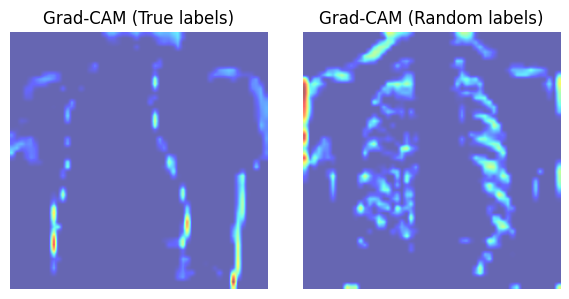

Processing sample 1 (label: Normal)
 → Spearman ABS: 0.0736, Diverging: 0.0736


<Figure size 640x480 with 0 Axes>

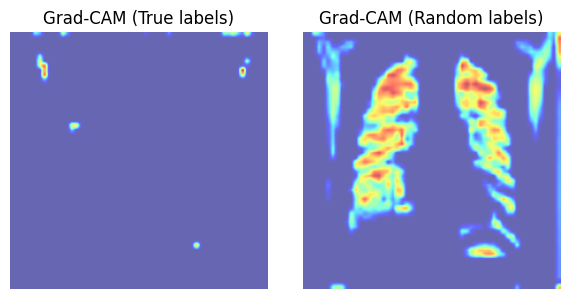

Processing sample 2 (label: Normal)
 → Spearman ABS: -0.1229, Diverging: -0.1229


<Figure size 640x480 with 0 Axes>

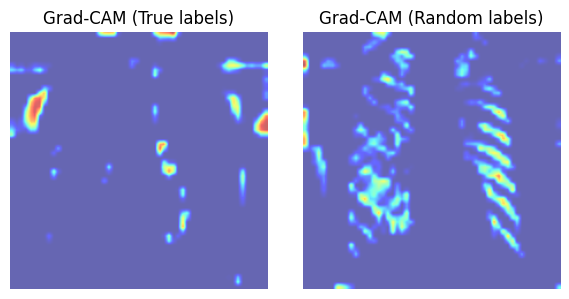

Processing sample 3 (label: Normal)
 → Spearman ABS: 0.4498, Diverging: 0.4498


<Figure size 640x480 with 0 Axes>

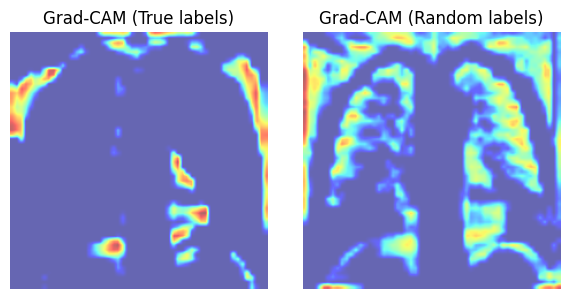

Processing sample 4 (label: Normal)
 → Spearman ABS: 0.1628, Diverging: 0.1628


<Figure size 640x480 with 0 Axes>

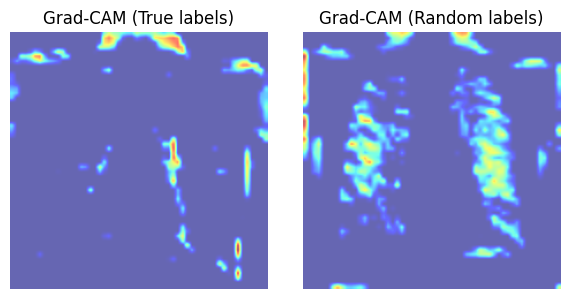

Processing sample 5 (label: Pneumonia)
 → Spearman ABS: -0.0185, Diverging: -0.0185


<Figure size 640x480 with 0 Axes>

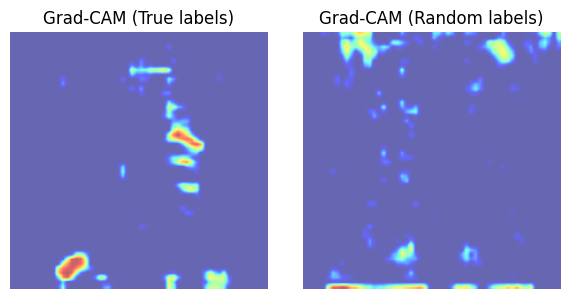

Processing sample 6 (label: Pneumonia)
 → Spearman ABS: -0.0524, Diverging: -0.0524


<Figure size 640x480 with 0 Axes>

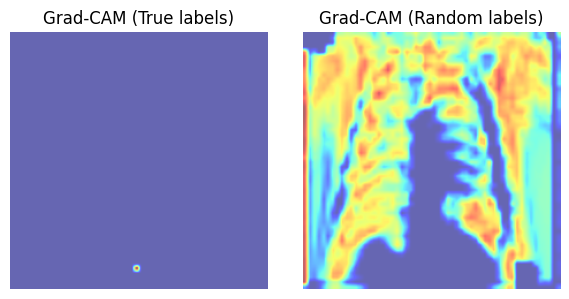

Processing sample 7 (label: Pneumonia)
 → Spearman ABS: 0.4449, Diverging: 0.4449


<Figure size 640x480 with 0 Axes>

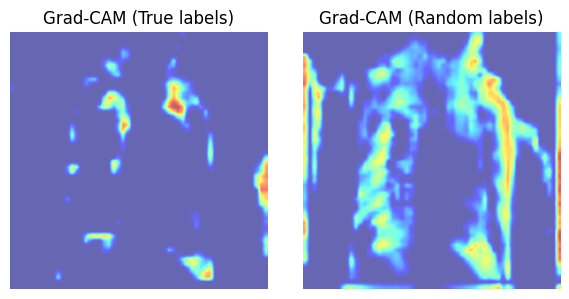

Processing sample 8 (label: Pneumonia)
 → Spearman ABS: 0.4963, Diverging: 0.4963


<Figure size 640x480 with 0 Axes>

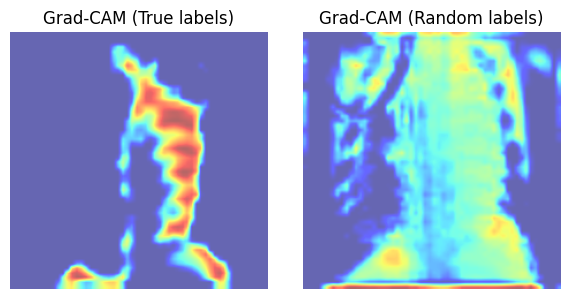

Processing sample 9 (label: Pneumonia)
 → Spearman ABS: 0.3514, Diverging: 0.3514


<Figure size 640x480 with 0 Axes>

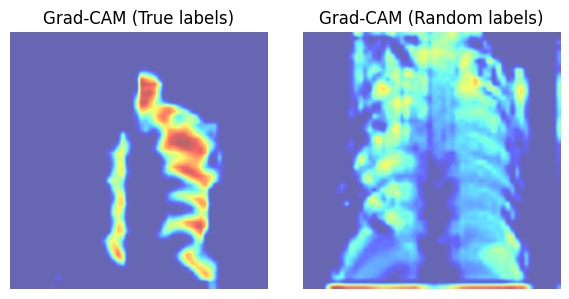


=== Average Spearman Correlation (Grad-CAM) ===
Mean Spearman (ABS): 0.1820
Mean Spearman (Diverging): 0.1820


<Figure size 640x480 with 0 Axes>

In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import os
from scipy.stats import spearmanr

# Assuming GradCAM class is implemented elsewhere
# and you have `SimpleCNN`, `test_ds`, `PROJ_ROOT`, `FIG_DIR` available

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# Load the random-label model
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "random_labels_model_final.pt"
rnd_model = SimpleCNN().to(device)
rnd_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
rnd_model.eval()

# Set up GradCAM
target_layer = model.features[6]
target_layer_rnd = rnd_model.features[6]
gc = GradCAM(model, target_layer)
gc_rnd = GradCAM(rnd_model, target_layer_rnd)

# Select 5 normal and 5 pneumonia samples
idx_norm = [i for i, (_, lbl) in enumerate(test_ds) if lbl == 0][:5]
idx_pneu = [i for i, (_, lbl) in enumerate(test_ds) if lbl == 1][:5]
subset = Subset(test_ds, idx_norm + idx_pneu)
loader = DataLoader(subset, batch_size=1, shuffle=False)

# Compute Spearman correlation
def compute_spearman(attr1, attr2, abs_val=True):
    a1 = attr1.flatten()
    a2 = attr2.flatten()
    if abs_val:
        a1 = np.abs(a1)
        a2 = np.abs(a2)
    return spearmanr(a1, a2).correlation

# Output directory
output_dir = PROJ_ROOT / "reports" / "figures" / "gradcam_individual_images"
os.makedirs(output_dir, exist_ok=True)

# Store correlation scores
spearman_abs_list = []
spearman_div_list = []

# Attribution loop
for i, (img, lbl) in enumerate(loader):
    img = img.to(device)
    lbl = lbl.item()
    print(f"Processing sample {i} (label: {'Pneumonia' if lbl else 'Normal'})")
    
    # Compute Grad-CAM maps
    cam = gc.generate(img, target_index=0)
    cam_rnd = gc_rnd.generate(img, target_index=0)

    # Spearman correlations
    corr_abs = compute_spearman(cam, cam_rnd, abs_val=True)
    corr_div = compute_spearman(cam, cam_rnd, abs_val=False)

    spearman_abs_list.append(corr_abs)
    spearman_div_list.append(corr_div)

    print(f" → Spearman ABS: {corr_abs:.4f}, Diverging: {corr_div:.4f}")

    # Plot Grad-CAM maps
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, im, title in zip(axes, [cam, cam_rnd],
                             ["Grad-CAM (True labels)", "Grad-CAM (Random labels)"]):
        ax.imshow(im, cmap="jet", alpha=0.6)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Save
    output_path = output_dir / f"gradcam_sample_{i}_label_{lbl}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

# Print average Spearman correlation
print(f"\n=== Average Spearman Correlation (Grad-CAM) ===")
print(f"Mean Spearman (ABS): {np.mean(spearman_abs_list):.4f}")
print(f"Mean Spearman (Diverging): {np.mean(spearman_div_list):.4f}")


Same thing as before. Metrics

In [92]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import os
from scipy.stats import spearmanr
from tqdm import tqdm  # for progress bar

# Assuming GradCAM class and other imports are already available

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "simple_cnn_model_final.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# Load the random-label model
CHECKPOINT_PATH = PROJ_ROOT / "models" / "cnn" / "random_labels_model_final.pt"
rnd_model = SimpleCNN().to(device)
rnd_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
rnd_model.eval()

# Set up GradCAM
target_layer = model.features[6]
target_layer_rnd = rnd_model.features[6]
gc = GradCAM(model, target_layer)
gc_rnd = GradCAM(rnd_model, target_layer_rnd)

# Create DataLoader for the full test set
loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Compute Spearman correlation
def compute_spearman(attr1, attr2):
    a1 = attr1.flatten()
    a2 = attr2.flatten()
    
    # Check if either array is constant (i.e., all values are the same)
    if np.all(a1 == a1[0]) or np.all(a2 == a2[0]):
        return float('nan')  # Return NaN if either array is constant
    
    return spearmanr(a1, a2).correlation


# Output directory
output_dir = PROJ_ROOT / "reports" / "figures" / "gradcam_full_test_set_with_baseline"
os.makedirs(output_dir, exist_ok=True)

# Store correlation scores
spearman_list = []  # Trained vs Random-Label
spearman_baseline_list = []  # Trained vs Random Noise

# Attribution loop for the full test set with a progress bar
for i, (img, lbl) in tqdm(enumerate(loader), total=len(loader), desc="Processing samples"):
    img = img.to(device)
    lbl = lbl.item()
    
    # Compute Grad-CAM maps
    cam = gc.generate(img, target_index=0)
    cam_rnd = gc_rnd.generate(img, target_index=0)
    
    # Generate random saliency maps (random noise)
    random_map = np.random.rand(*cam.shape)  # Random noise map of the same shape
    
    # Spearman correlations
    corr = compute_spearman(cam, cam_rnd)
    corr_baseline = compute_spearman(cam, random_map)

    spearman_list.append(corr)
    spearman_baseline_list.append(corr_baseline)

    # Save Grad-CAM maps as images (optional)
    #fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    #axes[0].imshow(cam, cmap="jet", alpha=0.6)
    #axes[0].set_title("Grad-CAM (True labels)")
    #axes[0].axis("off")
    
    #axes[1].imshow(cam_rnd, cmap="jet", alpha=0.6)
    #axes[1].set_title("Grad-CAM (Random labels)")
    #axes[1].axis("off")
    
    #axes[2].imshow(random_map, cmap="jet", alpha=0.6)
    #axes[2].set_title("Random Noise Map")
    #axes[2].axis("off")
    
    #plt.tight_layout()
    #output_path = output_dir / f"gradcam_sample_{i}_label_{lbl}.png"
    #plt.savefig(output_path, dpi=150, bbox_inches='tight')
    #plt.close(fig)

# Print average Spearman correlation after loop is done
print(f"\n=== Average Spearman Correlation (Trained vs Random-Label) ===")
print(f"Mean Spearman: {np.nanmean(spearman_list):.4f}")

print(f"\n=== Baseline: Trained vs Random Noise ===")
print(f"Mean Spearman: {np.nanmean(spearman_baseline_list):.4f}")


Processing samples:   0%|          | 0/624 [00:00<?, ?it/s]c:\Users\Menelao\Desktop\Health_care\project-1-ml4hc\venv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Processing samples: 100%|██████████| 624/624 [06:32<00:00,  1.59it/s]


=== Average Spearman Correlation (Trained vs Random-Label) ===
Mean Spearman: 0.2225

=== Baseline: Trained vs Random Noise ===
Mean Spearman: 0.0001


---

## Q5.3 – Elaborate on the Results

Integrated Gradients (IG): ✅ Passes

When we compare IG heatmaps from the correctly trained model versus the model trained on randomized labels (see Figure ig_sanity_test.png), the attribution patterns change meaningfully. In the true-label model, IG highlights relevant regions such as pulmonary opacities for pneumonia cases and broader, more uniform textures for healthy lungs. After label randomization, these same test images produce chaotic, inconsistent, or non-localized attributions, confirming that IG responds to the model’s actual decision function rather than superficial image statistics. This sensitivity validates IG as a faithful interpretability method in this context.

Grad-CAM (GC): ✅ Passes

Contrary to initial expectations, Grad-CAM also shows different attribution maps between the correctly trained model and the one trained on shuffled labels (see Figure gradcam_sanity_test.png). While Grad-CAM tends to produce smoother and more spatially constrained maps than IG, the highlighted regions change significantly after label randomization—particularly in their spatial focus and intensity. This suggests that Grad-CAM is not merely a generic edge or structure detector; it does in fact reflect class-discriminative patterns learned by the network. The difference in Grad-CAM maps implies that the final convolutional features and gradients are influenced by the supervision signal, supporting the claim that Grad-CAM is also model-sensitive in this setting.


---